In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('polusi-jaksel-2010-2021-no-knn.csv')
df

,Unnamed: 0,tanggal,pm10,so2,co,o3,no2,max,critical,categori
0,0,2010-01-01,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,1,2010-01-02,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2,2010-01-03,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,3,2010-01-04,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,4,2010-01-05,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4378,4378,2021-12-27,75.0,35.0,23.0,38.0,21.0,116.0,1.0,3.0
4379,4379,2021-12-28,51.0,NaN,13.0,17.0,18.0,74.0,1.0,1.0
4380,4380,2021-12-29,47.0,21.0,12.0,20.0,9.0,54.0,1.0,1.0
4381,4381,2021-12-30,60.0,21.0,15.0,19.0,13.0,60.0,3.0,1.0


In [3]:
df = df[['tanggal', 'categori']]
df.head()

,tanggal,categori
0,2010-01-01,NaN
1,2010-01-02,NaN
2,2010-01-03,NaN
3,2010-01-04,NaN
4,2010-01-05,NaN


In [4]:
df.tail()

,tanggal,categori
4378,2021-12-27,3.0
4379,2021-12-28,1.0
4380,2021-12-29,1.0
4381,2021-12-30,1.0
4382,2021-12-31,1.0


In [5]:
df.dtypes

tanggal      object
categori    float64
dtype: object

In [6]:
df = df.dropna()
df.head()

,tanggal,categori
310,2010-11-07,1.0
311,2010-11-08,1.0
312,2010-11-09,1.0
313,2010-11-10,4.0
314,2010-11-11,3.0


In [7]:
df.shape

(3980, 2)

In [8]:
df.replace({'SEDANG':2, 'BAIK':1, 'TIDAK SEHAT':3, 'SANGAT TIDAK SEHAT':4,'BERBAHAYA':5}, inplace=True)
df.astype({"categori":float})
df

,tanggal,categori
310,2010-11-07,1.0
311,2010-11-08,1.0
312,2010-11-09,1.0
313,2010-11-10,4.0
314,2010-11-11,3.0
...,...,...
4378,2021-12-27,3.0
4379,2021-12-28,1.0
4380,2021-12-29,1.0
4381,2021-12-30,1.0


In [9]:
df.dtypes

tanggal      object
categori    float64
dtype: object

In [10]:
df = df.astype({"categori": float})
df["tanggal"] = pd.to_datetime(df.tanggal, format="%Y-%m-%d")

df.dtypes

tanggal     datetime64[ns]
categori           float64
dtype: object

In [11]:
df.index = df['tanggal']

In [12]:
df

,tanggal,categori
tanggal,,
2010-11-07,2010-11-07,1.0
2010-11-08,2010-11-08,1.0
2010-11-09,2010-11-09,1.0
2010-11-10,2010-11-10,4.0
2010-11-11,2010-11-11,3.0
...,...,...
2021-12-27,2021-12-27,3.0
2021-12-28,2021-12-28,1.0
2021-12-29,2021-12-29,1.0


In [13]:
df.describe()

,categori
count,3980.000000
mean,1.531658
std,0.766707
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


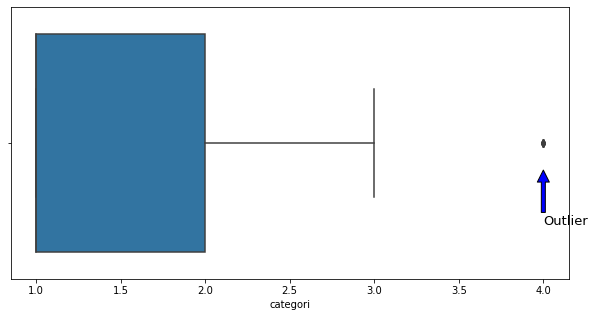

In [14]:
plt.figure(figsize = (10, 5))
sns.boxplot(df['categori']) 
plt.annotate('Outlier', (df['categori'].describe()['max'],0.1), xytext = (df['categori'].describe()['max'],0.3), 
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 ) 

IQR = df['categori'].describe()['75%'] - df['categori'].describe()['25%']

In [15]:
def detect_outliers(df,x): 
    Q1 = df[x].describe()['25%'] 
    Q3 = df[x].describe()['75%'] 
    IQR = Q3-Q1 
    return df[(df[x] < Q1-1.5*IQR) | (df[x] > Q3+1.5*IQR)]

In [16]:
detect_outliers(df, x ='categori')

,tanggal,categori
tanggal,,
2010-11-10,2010-11-10,4.0
2010-11-18,2010-11-18,4.0
2010-11-22,2010-11-22,4.0
2010-12-24,2010-12-24,4.0
2011-10-11,2011-10-11,4.0
2011-10-12,2011-10-12,4.0
2012-10-19,2012-10-19,4.0
2012-10-20,2012-10-20,4.0
2012-12-11,2012-12-11,4.0


In [17]:
df = df.drop((df[df['categori']>3.5]).index, axis=0)

In [18]:
detect_outliers(df, x ='categori')

,tanggal,categori
tanggal,,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


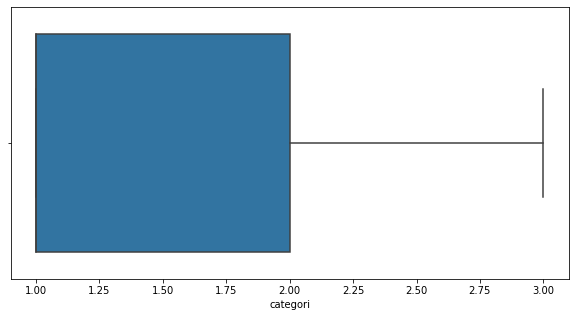

In [19]:
plt.figure(figsize = (10, 5)) 
sns.boxplot(df['categori']) 
plt.show()

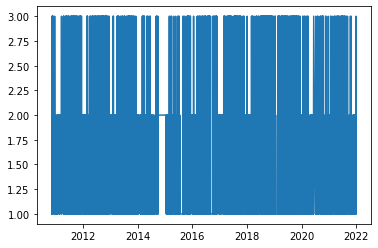

In [20]:
plt.plot(df["categori"],label='Kategori Polusi PerHari')

In [21]:
df_cat = df[['categori']]

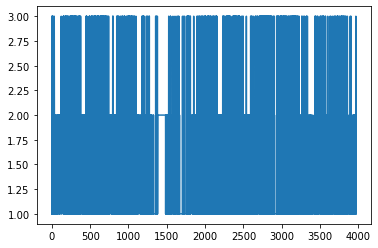

In [22]:
df_cat_val = df_cat.values
plt.plot(df_cat_val)

In [23]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
df_scaled = normalizer.fit_transform(np.array(df_cat_val).reshape(-1,1))

In [24]:
len(df_scaled), len(df_cat_val)

(3971, 3971)

In [25]:
#Defining test and train data sizes
train_size = int(len(df_scaled)*0.80)
test_size = len(df_scaled) - train_size

In [26]:
train_size,test_size

(3176, 795)

In [27]:
#Splitting data between train and test
df_train, df_test = df_scaled[0:train_size,:], df_scaled[train_size:len(df_scaled),:1]

In [28]:
len(df_train),len(df_test)

(3176, 795)

In [29]:
#creating dataset in time series for LSTM model 
def new_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [30]:
time_stamp = 100
X_train, y_train = new_ds(df_train,time_stamp)
X_test, y_test = new_ds(df_test,time_stamp)

In [31]:
X_train.shape,y_train.shape

((3075, 100), (3075,))

In [32]:
X_test.shape, y_test.shape

((694, 100), (694,))

In [33]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [34]:
# create and fit the LSTM network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.LSTM(50, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(1, activation='tanh'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-traina

In [36]:
#Training model with adam optimizer and mean squared error loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse',optimizer=optimizer)
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=150,
    batch_size=64,
    validation_split=0.3,
    verbose=1,
    )

Epoch 1/150
34/34 [==============================] - 15s 257ms/step - loss: 0.1394 - val_loss: 0.1814
Epoch 2/150
34/34 [==============================] - 7s 211ms/step - loss: 0.1320 - val_loss: 0.1780
Epoch 3/150
34/34 [==============================] - 7s 214ms/step - loss: 0.1315 - val_loss: 0.1811
Epoch 4/150
34/34 [==============================] - 7s 214ms/step - loss: 0.1317 - val_loss: 0.1780
Epoch 5/150
34/34 [==============================] - 7s 217ms/step - loss: 0.1311 - val_loss: 0.1780
Epoch 6/150
34/34 [==============================] - 7s 213ms/step - loss: 0.1314 - val_loss: 0.1795
Epoch 7/150
34/34 [==============================] - 8s 225ms/step - loss: 0.1309 - val_loss: 0.1779
Epoch 8/150
34/34 [==============================] - 9s 256ms/step - loss: 0.1308 - val_loss: 0.1775
Epoch 9/150
34/34 [==============================] - 7s 217ms/step - loss: 0.1302 - val_loss: 0.1781
Epoch 10/150
34/34 [==============================] - 8s 228ms/step - loss: 0.1313 - val_l

In [37]:
# Convert the model.
import pathlib

export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [38]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

228016

In [39]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

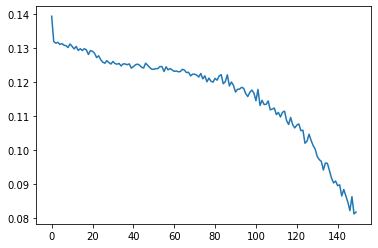

In [40]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [41]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [42]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

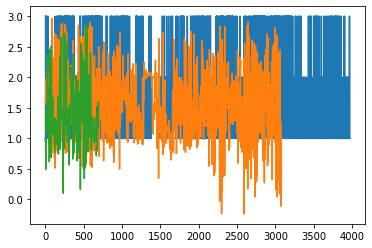

In [43]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(df_scaled))
plt.plot(train_predict) #Orange Training
plt.plot(test_predict) #Green Testing

In [44]:
type(train_predict)

numpy.ndarray

In [45]:
test = np.vstack((train_predict,test_predict))

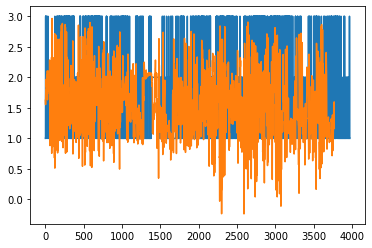

In [46]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(df_scaled))
plt.plot(test)

In [47]:
len(df_test)

795

In [48]:
#Getting the last 100 days records
fut_inp = df_test[len(df_test)-100:]
fut_inp = fut_inp.reshape(1,-1)

fut_inp.shape

(1, 100)

In [49]:
#Creating list of the last 100 data
tmp_inp = list(fut_inp)
tmp_inp = tmp_inp[0].tolist()

In [50]:
from datetime import datetime

# Predicting from last date of dataset untill today
date_dataset = '2021/12/31'
date_today = '2022/06/08'

# convert string to date object
d1 = datetime.strptime(date_dataset, "%Y/%m/%d")
d2 = datetime.strptime(date_today, "%Y/%m/%d")

# difference between dates in timedelta
delta = d2 - d1
delta = int(delta.days)
print(f'Difference is {delta} days')

Difference is 159 days


In [51]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
i=0
while(i<delta):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, time_stamp, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, time_stamp,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[-0.020037025213241577], [-0.030311962589621544], [0.008463440462946892], [0.09261194616556168], [0.18884502351284027], [0.24509814381599426], [0.2214936465024948], [0.13996876776218414], [0.032653190195560455], [-0.016444748267531395], [-0.019675910472869873], [-0.014466227032244205], [-0.015497813932597637], [-0.01940782181918621], [-0.01911911368370056], [-0.00958779826760292], [0.011980182491242886], [0.04703177511692047], [0.09339664876461029], [0.14117346704006195], [0.17323558032512665], [0.17659929394721985], [0.16108964383602142], [0.16828781366348267], [0.13054493069648743], [0.09961400926113129], [0.08009610325098038], [0.07083676755428314], [0.06890279799699783], [0.07371445000171661], [0.08754695951938629], [0.11343314498662949], [0.10452650487422943], [0.09858104586601257], [0.08105508983135223], [0.062306296080350876], [0.051049672067165375], [0.04940436780452728], [0.054068777710199356], [0.05299963429570198], [0.05743344873189926], [0.06399755924940109], [0.0704150870

In [52]:
hasil = normalizer.inverse_transform(lst_output)
hasil = np.array(hasil)
hasil = hasil[-1]
hasil_float = hasil.astype(np.float32)
polusi = int(hasil_float)

# df.replace({'SEDANG':2, 'BAIK':1, 'TIDAK SEHAT':3, 'SANGAT TIDAK SEHAT':4,'BERBAHAYA':5}, inplace=True)

if polusi >= 1 and polusi < 2:
    print("Polusi = Baik ke Sedang")
elif polusi >= 2 and polusi < 3:
    print("Polusi = Sedang ke Tidak Sehat, Pakailah Maskerr !! ")
elif polusi >= 3 and polusi < 4:
    print("Polusi = Tidak Sehat, Pakailah Maskerr !!")
elif polusi >= 4 and polusi < 5:
    print("Polusi = Sangat Tidak Sehat, Pakailah Maskerr !!")
elif polusi >= 5:
    print("Polusi = Berbahaya, Pakailah Maskerr !!")


Polusi = Baik ke Sedang


In [53]:
len(df_scaled)

3971

In [54]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,time_stamp+1)
plot_pred=np.arange(time_stamp+1,time_stamp+1+delta)

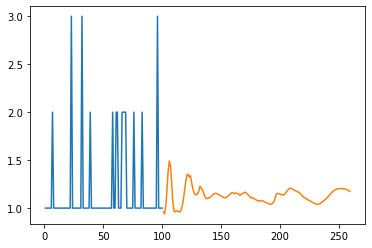

In [55]:
plt.plot(plot_new, normalizer.inverse_transform(df_scaled[len(df_scaled)-time_stamp:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [56]:
df_new = df_scaled.tolist()

In [57]:
len(df_new)

3971

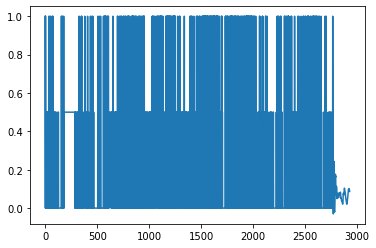

In [58]:
#Entends helps us to fill the missing value with approx value
df_new.extend(lst_output)
plt.plot(df_new[1200:])

In [59]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(df_new).tolist()

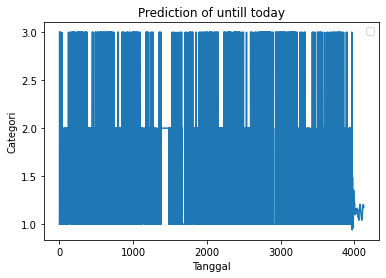

In [60]:
#Plotting final results with predicted value till today
plt.plot(final_graph,)
plt.ylabel("Categori")
plt.xlabel("Tanggal")
plt.title("Prediction of untill today")
plt.legend()